# Portfolio 4: Analysis of Consumer Finance Survey

## Analysis proposal
One of the residual effect of COVID-19 pandemic is the surge in the number of investors as technology makes it much easier to participate in the financial market. For many funds managers, it would probably be helpful to build a profile of possible clients based on the the ability to take risks as well as other helpful attributes. 

This portfolio will attempt to focus on business owners in the US, since this segment of the population is more prone to external shocks, instead of the whole population. Based on the dataset, we are interested in learning:

<div class="alert alert-block alert-info">
<ol>
  <li> How can we cluster business owners in the US to better identify different types of investors?</li>
  <li> What are the influential attributes in determining the clusters?
</li>

</div>

In [127]:
#Import libraries
import pandas as pd
import numpy as np
import rowgenerators as rg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from rowgenerators import  parse_app_url
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cut_tree
from scipy.spatial.distance import pdist,squareform
from scipy.stats.mstats import trimmed_var

In [128]:
#Display format option, palette
palette = ["#2c69b0", "#b5c8e2", "#f02720", "#ffb6b0", "#ac613c", "#e9c39b","#6ba3d6","#b5e9fd","#ac8763","#ddc9b4","#bd0a36", "#f4737a"]
sns.set_palette(palette)
pd.options.display.float_format = '{:,.2f}'.format

## Data source

To achieve this, we will make use of the Survey of Consumer Finance (SCF), which is sponsored by the US Federal Reserve and can be found at this [website](https://www.federalreserve.gov/econres/scfindex.htm). The survey tracks balance sheets, pensions, income and demographical information about families in the US. The survey is conducted every 3 years . For simplicity and computational ability, we will look at the public extract data for the year 2022, which can be found on the same site. 

In [129]:
#Function to download data from the Federal Reserve website
#Select the public extract file
#display dataframe
def wrangle(url, folder, filename):
    df = rg.dataframe(url+folder+"#"+filename)
    return df

In [130]:
#Read data from url into a dataframe name scfe
#View first 5 rows
url = "https://www.federalreserve.gov/econres/files/"
folder = "scfp2022s.zip"
filename = "rscfp2022.dta"
scfe = wrangle(url, folder, filename)
scfe.head()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,nwcat,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat
0,1,11,"3,027.96",2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,2,1
1,1,12,"3,054.90",2,70,5,9,3,2,2,...,4,2,5,2,1,8,3,3,2,1
2,1,13,"3,163.64",2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,1,1
3,1,14,"3,166.23",2,70,5,9,3,2,2,...,3,2,4,1,1,6,3,2,1,1
4,1,15,"3,235.62",2,70,5,9,3,2,2,...,3,2,4,2,1,8,3,3,1,1


This is a large dataset with almost 25,000 rows and 357 columns. At the same time, some index can be quite difficult to decipher and read. This [Codebook](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbkfx0.htm) contains explanations for all the features. For this portfolio, we will only focus on *business owners* and some of the demographical and financial data. Some simple descriptive statistics can be found below.

In [131]:
#Data shape
print(f"The shape of the data is: {scfe.shape}")


The shape of the data is: (22975, 357)


In [132]:
#Descriptive information about the survey
#Calculate weight to get at the number of households
number = int(scfe["wgt"].sum())
print(f"Number of participants in the survey: {len(scfe.index):,}")
print(f"Number of households represented in the survey: {round(number,0):,}")

Number of participants in the survey: 22,975
Number of households represented in the survey: 131,306,389


In [133]:
#Mask data to only business owners
#`hbus` is defined as "Have active or nonactively managed business(es)"
scfe_bus = scfe[scfe["hbus"] == 1]
scfe_bus.head()
scfe_bus.shape

(6386, 357)

## Data processing

As it is seen above, there is a column called **wgt** in the dataframe. This indicates that this is a weighted survey, with each column represent multiple households.

Therefore, in order to perform exploratory data analysis, it is necessary to sample the data so that the calculation is meaningful. Using this [guide](https://github.com/sandiegodata-projects/insights.sandiegodata.org/blob/main/tutorial/GettingStartedwithSCF.ipynb), we will be able to extract a sample using the pands method `sample` to perform basic data analysis.

In [134]:
#Create a dataframe that contains sampled data. For easy computational, we set sample size at 200k datapoints
dfs = scfe.sample(int(2e5), replace=True, weights = scfe["wgt"], random_state=42)

In [135]:
#Data shape
print(f"The shape of the data is: {dfs.shape}")

The shape of the data is: (200000, 357)


In [136]:
#Checking for any null values and removing the null values
print(f"Null Values = {dfs.isnull().values.any()}")

Null Values = False


## Exploratory Data Analysis

We begin by looking at the mean and median networth, income and asset of the sampled households

In [137]:
#Calculate weighted mean and median networth, income and asset of the sample
my_features = ["networth","asset", "income"]
mean_weighted = round(dfs[my_features].mean(),0)
median_weighted = round(dfs[my_features].median(),0)
basic_stats = pd.concat([mean_weighted, median_weighted], axis=1, keys = ["mean_weighted", "median_weighted"])
basic_stats


,mean_weighted,median_weighted
networth,"1,061,560.00","191,001.00"
asset,"1,187,862.00","331,200.00"
income,"142,508.00","70,259.00"


The large differences between mean and median for some of the financial attributes show that there are a lot of variances in our data. This would be helpful for creating clusters later on. However, this could also indicate we have outliers in this dataset which need to be removed later on. 

For this portfolio, we will focus on business owners. These households are identified in the "HBUS" column, which is defined as "Have active or nonactively managed business(es)
". 

In [138]:
#subset data to only business owners
dfs_bus = dfs[dfs["hbus"] == 1]
dfs_bus.head()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,nwcat,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat
19158,3839,38394,"6,704.88",1,30,1,11,3,1,0,...,3,4,3,4,2,7,7,7,3,3
13752,2756,27563,"8,605.92",1,45,3,4,1,1,10,...,1,2,1,2,1,3,4,4,2,2
4032,810,8103,"17,405.51",1,81,6,10,3,1,0,...,3,3,3,3,1,6,5,5,2,2
22231,4455,44552,"13,916.53",1,64,4,8,2,1,0,...,3,2,4,2,1,8,4,4,2,2
2293,460,4604,"7,985.99",1,63,4,12,4,1,1,...,1,2,1,2,1,2,3,4,2,2


In [139]:
#Descriptive statistics
dfs_bus.describe()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,nwcat,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat
count,"28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00",...,"28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00","28,813.00"
mean,"2,285.77","22,860.67","8,559.82",1.10,52.24,3.26,10.97,3.35,1.23,0.87,...,3.57,4.09,4.36,4.18,2.04,7.78,7.38,7.59,3.12,3.19
std,"1,287.45","12,874.50","5,386.31",0.30,15.34,1.50,2.34,0.89,0.42,1.26,...,1.30,1.64,1.52,1.58,0.75,2.88,3.04,2.90,1.06,1.00
min,2.00,24.00,2.87,1.00,22.00,1.00,2.00,1.00,1.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,"1,249.00","12,495.00","4,006.59",1.00,39.00,2.00,9.00,3.00,1.00,0.00,...,3.00,3.00,3.00,3.00,1.00,6.00,5.00,5.00,2.00,2.00
50%,"2,353.00","23,532.00","8,071.75",1.00,53.00,3.00,12.00,4.00,1.00,0.00,...,4.00,4.00,5.00,4.00,2.00,8.00,8.00,8.00,4.00,4.00
75%,"3,281.00","32,814.00","11,425.29",1.00,64.00,4.00,13.00,4.00,1.00,2.00,...,5.00,6.00,6.00,6.00,3.00,10.00,10.00,10.00,4.00,4.00
max,"4,601.00","46,015.00","24,145.61",2.00,95.00,6.00,14.00,4.00,2.00,10.00,...,5.00,6.00,6.00,6.00,3.00,12.00,12.00,12.00,4.00,4.00


### Age

Comment: The majority of business owners seem to be within the 50-70 age range. Where as for the population as a whole, there seems to be 2 major age groups: between 30-40 and 50-70. This makes sense since these are the working age. As people grow older, they seem to relenquish their roles in the business. 

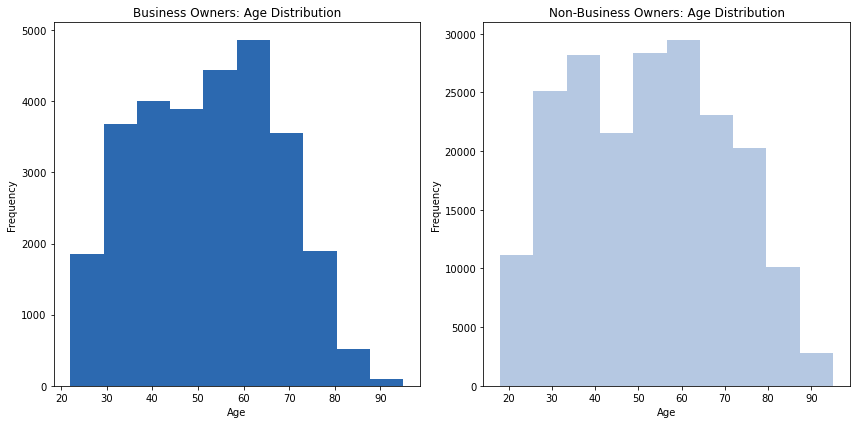

In [140]:
#Histogram of age for business owners and non-business owners
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].hist(dfs_bus["age"], bins=10, color="#2c69b0")
axes[0].set(title="Business Owners: Age Distribution", xlabel="Age", ylabel="Frequency")
axes[1].hist(dfs["age"], bins=10, color="#b5c8e2")
axes[1].set(title="Non-Business Owners: Age Distribution", xlabel="Age",ylabel="Frequency")
fig.tight_layout()
plt.show();

### Race

Comment: The majority of population in the US is White and this explains to some degree why almost 70% of business owners are White. 

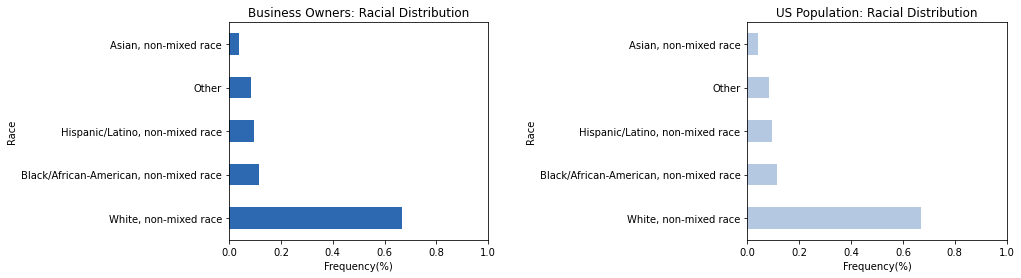

In [141]:
#Create a dictionary to store key-value pairs of race classification
race_dict = {
    1: "White, non-mixed race",
    2: "Black/African-American, non-mixed race",
    3: "Hispanic/Latino, non-mixed race",
    4: "Asian, non-mixed race",
    5: "Other"
}
#Replace numbers with actual title
race = dfs_bus["racecl5"].replace(race_dict).value_counts(normalize=True)
race_pop = race = dfs["racecl5"].replace(race_dict).value_counts(normalize=True)
# Create bar chart of race_value_counts
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1= race.plot(kind="barh", color="#2c69b0", ax=ax1)
ax1.set(title="Business Owners: Racial Distribution", xlabel="Frequency(%)", ylabel="Race")
ax1.set_xlim(0,1)
ax2 = race_pop.plot(kind="barh", color="#b5c8e2", ax=ax2)
ax2.set(title="US Population: Racial Distribution", xlabel="Frequency(%)",ylabel="Race")
ax2.set_xlim(0,1)
plt.subplots_adjust(left=0.2, right=2, wspace=1, hspace=1)
plt.show();

### Family

We explore the family dynamics of business owners. Almost 80% of business owners are either married or with a partner. However, more than half of the business owners do not have kids in the households. While non-business owners also don't seem to have kids, they also don't seem to be in a relationship. 

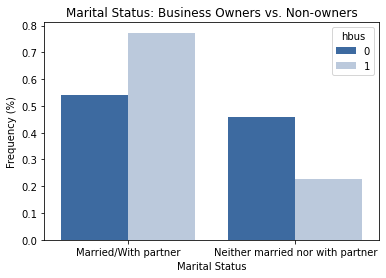

In [142]:
#Create a dict to change variable name
married_dict = {1: "Married/With partner", 
                2: "Neither married nor with partner"}

dfs_married = dfs["married"].replace(married_dict).groupby(dfs["hbus"]).value_counts(normalize=True).rename("Frequency").to_frame().reset_index()

#Plot marital status
sns.barplot(data=dfs_married, x="married", y="Frequency", hue="hbus", palette=palette)
plt.xlabel("Marital Status")
plt.ylabel("Frequency (%)")
plt.title("Marital Status: Business Owners vs. Non-owners");

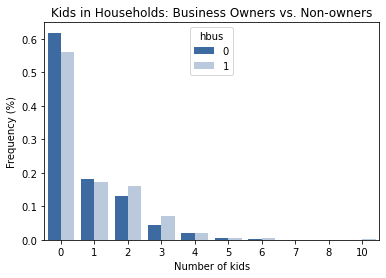

In [143]:
#Number of kids for (non) business owners
dfs_kids = dfs["kids"].groupby(dfs["hbus"]).value_counts(normalize=True).rename("Frequency").to_frame().reset_index()
#Plot
sns.barplot(data=dfs_kids, x="kids", y="Frequency", hue="hbus", palette=palette)
plt.xlabel("Number of kids")
plt.ylabel("Frequency (%)")
plt.title("Kids in Households: Business Owners vs. Non-owners");

### Education

In this plot, we can see that a much higher proportion of non-business owners respondents have only a high school diploma (group 8), while university degrees (group 12 onwards) are more common among the business owners. See [Codebook](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbkfx0.htm) for detailed explanation of education level displayed. 

In [144]:
#Create dataframe for normalized freq for education categories
dfs_edu = dfs["educ"].groupby(dfs["hbus"]).value_counts(normalize=True).rename("Frequency").to_frame().reset_index()
dfs_edu.head()

,hbus,educ,Frequency
0,0,8,0.25
1,0,12,0.23
2,0,9,0.16
3,0,13,0.10
4,0,10,0.07


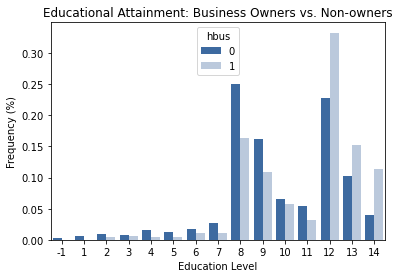

In [145]:
#visualize the "dfs_edu" dataframe
sns.barplot(data=dfs_edu, x="educ", y="Frequency", hue="hbus", palette=palette)
plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.title("Educational Attainment: Business Owners vs. Non-owners");

### Income

Comment: Comparing the subgroup of business owners to the whole population shows that business owners seem to be more common in the higher income group. Whereas the distribution of income categories for the population is more heavily towards low-mid income.

In [146]:
#normalize frequency for income categories for both business owners and non-owners
inccat_dict = {
    1: "0-20",
    2: "20-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}
#Create dataframe to store frequency of income category for (non) business owners
dfs_inccat = (dfs["inccat"]
            .replace(inccat_dict).groupby(dfs["hbus"]).value_counts(normalize=True)
            .rename("Frequency").to_frame().reset_index())
#dfs_inccat.style.format({'Frequency': '{:,.2f}'.format,})
dfs_inccat

,hbus,inccat,Frequency
0,0,0-20,0.22
1,0,20-39.9,0.21
2,0,40-59.9,0.21
3,0,60-79.9,0.20
4,0,80-89.9,0.09
5,0,90-100,0.07
6,1,90-100,0.29
7,1,60-79.9,0.21
8,1,80-89.9,0.16
9,1,40-59.9,0.14


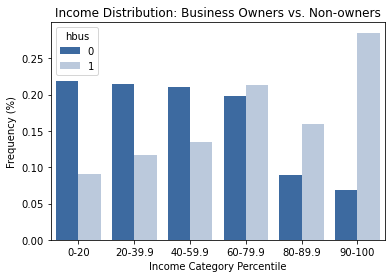

In [147]:
# Create bar chart of "df_inccat"
sns.barplot(data=dfs_inccat, x="inccat", y="Frequency", hue="hbus", palette=palette, order=inccat_dict.values())
plt.xlabel("Income Category Percentile")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-owners");

### Asset

Comment: We explore asset allocation by different networth groups. For business owners, the group with the highest net worth percentile (Group 12) tend to rely on the value of their business to boost networth as well as other assets (such as pensions incomes, IRA Roths, etc). While for most other groups, networth is mostly madae up of residential equity and vehicles ownership. 

In [148]:
#Dictionary to display name of assets
asset = {"asset": "Total Asset",
         "nnresre": "Non-Residential Real Estate",
         "houses": "Primary Residence",
         "vehic": "Vehicles",
         "prepaid": "Prepaid Cards",
         "othfin": "Other Financial Assets",
         "othnfin": "Other Nonfinancial Assets",
         "actbus": "Business Interest",
         "cashli": "Life Insurance",
         "currpen": "Pension", 
         "deq": "Stocks and Funds",
         "cds": "Certificate of Deposits",
}
#Get key of dict
key_asset = list(asset.keys())

In [149]:
#Calculate asset allocation 
allocation = pd.DataFrame(dfs_bus.groupby("nwpctlecat")[key_asset].sum())
allocation.iloc[:,0:17] = allocation.iloc[:,0:17].div(allocation.iloc[:,0], axis=0)
#Create "other" column
allocation["sum"] = allocation[key_asset[1:]].sum(axis=1)
allocation["other"] = allocation["asset"] - allocation["sum"]
allocation.drop(columns=["sum"], inplace=True)
allocation=allocation.reset_index()
#update asset 
asset["other"] = "Other"
key_asset = list(asset.keys())
key_values = list(asset.values())

<Figure size 1152x576 with 0 Axes>

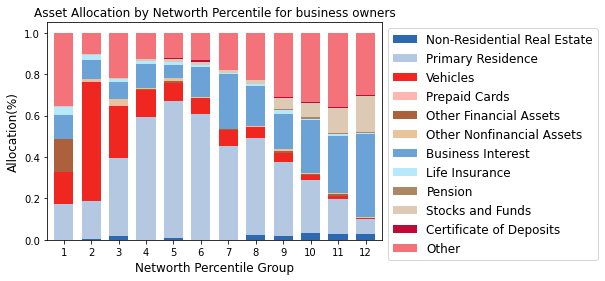

In [150]:
#Visualize allocation
fig = plt.figure(figsize=(16,8))
allocation[key_asset[1:]].plot(kind="bar", stacked=True, width=0.7,color=palette)
plt.legend(bbox_to_anchor = (1,1), labels=key_values[1:], fontsize=12)
plt.xticks(rotation=0)
plt.xticks(allocation.index, allocation["nwpctlecat"].values)
plt.ylabel("Allocation(%)", fontsize = 12)
plt.xlabel("Networth Percentile Group", fontsize = 12)
plt.title("Asset Allocation by Networth Percentile for business owners",fontsize = 12)
#plt.legend(bbox_to_anchor = (1,1), fontsize=12)
plt.show();

## Feature selection

The data analysis above shows that the profile of clusters of investors could be built by selecting both financial and demographical features. We can perform feature selection by using domain knowledge. 

### Financial features

To select financial features, it would make sense to select numerical features that have high variance as they would lead to better clustering. The distinction would encourage natural grouping. However, as it is shown below, a number of the wealth indicators are highly skewed with outliers having a lot of wealth. Therefore, we will use trimmed variance, which means removing extreme values before calculating variance. We implement this by making use of the `trimmed_variance` function from the scipy library. 

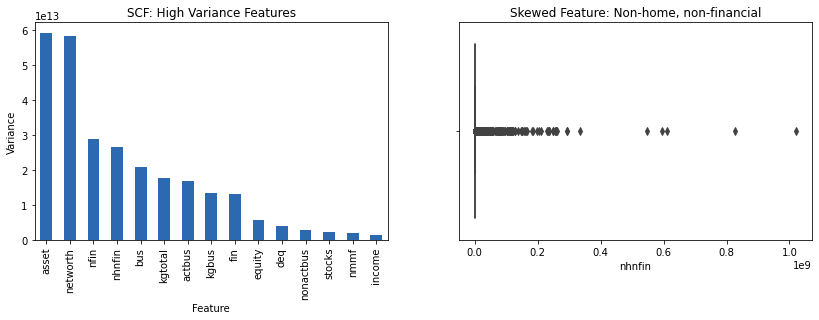

In [151]:
#Calculate variance, get 15 largest features
#Plot the 15 largest features
fig, (ax1, ax2) = plt.subplots(1, 2)
top_ten_var = dfs.var().nlargest(15)
ax1= top_ten_var.plot(kind="bar", color="#2c69b0", ax=ax1)
ax1.set(title="SCF: High Variance Features", xlabel="Feature", ylabel="Variance")
#Plot one of the highly skewed feature
ax2 = sns.boxplot(data = dfs, x="nhnfin", ax=ax2)
ax2.set(title="Skewed Feature: Non-home, non-financial")
plt.subplots_adjust(left=0.2, right=2, wspace=0.2, hspace=1)
plt.show();

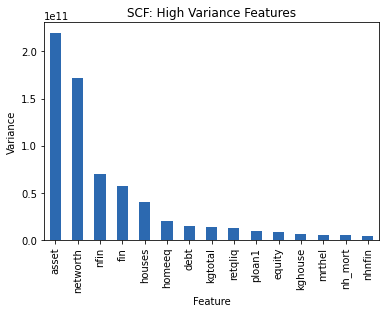

In [152]:
#Calculate trimmed variance
#Get top 15 highes trimmed variance features
top_trim_var = dfs.apply(trimmed_var).nlargest(15)
#plot the high trimmed variance features
top_trim_var.plot(kind="bar", color="#2c69b0")
plt.title("SCF: High Variance Features")
plt.xlabel("Feature")
plt.ylabel("Variance");

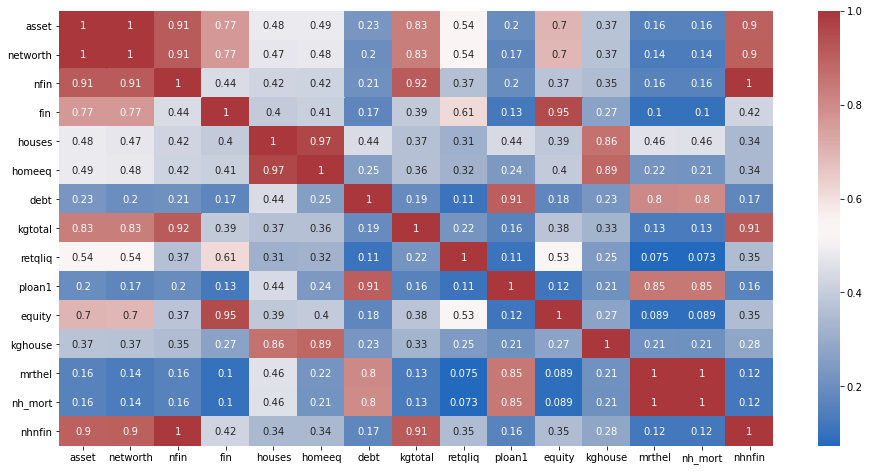

In [153]:
#Select 6 features with highest trimmed variance, avoid high correlation
fin_features = top_trim_var.index.to_list()
corr = dfs_bus[fin_features].corr()
fig = plt.figure(figsize=(16,8))
sns.heatmap(corr, annot=True, cmap="vlag")
fin_features = ["asset", "nfin", "fin", "houses", "debt", "kgtotal"]

### Demographical and Other Features

At the same time, it would also be useful to include in features that can profile an investors by their demographical and attitudinal attributes. We attempt to select these features from the exploratory data analysis above.  

In [154]:
# create list of demographical features
demo_features = ["agecl","spendmor", "educ", "married", "lifecl", "kids", "yesfinrisk"]

After the selections, we are going to work with these features going forward

| Variables  | Description  |
|---|---|
| asset |Total value of assets held by household, 2022 dollars   |
| nfin  | Total value of nonfinancial assets held by household, 2022 dollars   |
| fin  | Total value of financial assets held by household, 2022 dollars  |
| houses  |Total value of primary residence of household, 2022 dollars   |
| debt  |	Total value of debt held by household, 2022 dollars   |
| kgtotal  |Total unrealized capital gains or losses for the household, 2022 dollars   |
| agecl  | 	Age group of the reference person  |
| spendmor  |Respondents would spend more if assets appreciated in value   |
| educ  | Highest completed grade by reference person  |
| married  | 	Marital status of reference person  |
| lifecl  | 	Life cycle of reference person  |
| kids  |Total number of children in household   |
| yesfinrisk  | Respondent willing to take financial risk  |

## Build Model

To further enhance the clustering process, we will remove outliers form the selected financial features

In [155]:
# Calculate quantiles and IQR
Q1 = scfe_bus[fin_features].quantile(0.25) 
Q3 = scfe_bus[fin_features].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((scfe_bus[fin_features] < (Q1 - 1.5 * IQR)) | (scfe_bus[fin_features] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_scfe = scfe_bus[condition]

filtered_scfe.head()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,nwcat,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat
5,2,21,236.63,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
6,2,22,245.85,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
7,2,23,253.10,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
8,2,24,252.91,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
9,2,25,253.81,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4


### K Means Clustering

We use K Means model in order to perform clustering analysis. Since KMeans depend on calculating and minimizing intra-cluster distance, it would best be used on numberical data

In [156]:
#Select dataframe containing selected financial features to fit KMeans first
X = filtered_scfe[fin_features].astype("float32")
X.head()

,asset,nfin,fin,houses,debt,kgtotal
5,"1,240,500.00","1,100,000.00","140,500.00","580,000.00","518,700.00","164,000.00"
6,"1,242,500.00","1,100,000.00","142,500.00","580,000.00","518,700.00","164,000.00"
7,"1,241,100.00","1,100,000.00","141,100.00","580,000.00","519,700.00","164,000.00"
8,"1,244,000.00","1,100,000.00","144,000.00","580,000.00","519,700.00","164,000.00"
9,"1,241,300.00","1,099,000.00","142,300.00","580,000.00","518,700.00","164,000.00"


Since KMeans as well as other clustering methods are sensitive to scale, we have to include scaler

In [157]:
#Instantiate transformer
ss = StandardScaler()

#Transform "X"
X_scaled_data = ss.fit_transform(X)

#Put "X_scaled_data" into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()


X_scaled shape: (4596, 6)


,asset,nfin,fin,houses,debt,kgtotal
0,-0.62,-0.50,-0.54,-0.37,0.67,-0.52
1,-0.62,-0.50,-0.54,-0.37,0.67,-0.52
2,-0.62,-0.50,-0.54,-0.37,0.68,-0.52
3,-0.62,-0.50,-0.54,-0.37,0.68,-0.52
4,-0.62,-0.50,-0.54,-0.37,0.67,-0.52


#### Finding optimal number of k

In order to find the optimal number of k, we can use 2 methods such as:
- Elbow method with *Inertia*: Inertia is defined as the mean squared distance between each instance and its closest centroid. Therefore, we would want to select a k at which, inertia is increasingly becoming lower. 
- *Silhouette Score*: Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation) and is in the range from (-1, 1). The higher the Silhouette score, the more well-clustered the data is. 

In [158]:
#Use a for loop to build and train KMeans model with a range of number of clusters
#Add sample weight to assign weight to observations
n_clusters = range(2, 9)
inertia_errors = []
silhouette_scores = []
sample_weight = filtered_scfe["wgt"]

In [159]:
# Add for loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    #train model
    model.fit(X_scaled, sample_weight=sample_weight)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [22593024.0, 16758070.0, 14681345.0]

Silhouette Scores: [0.43608838, 0.4081312, 0.40191975]


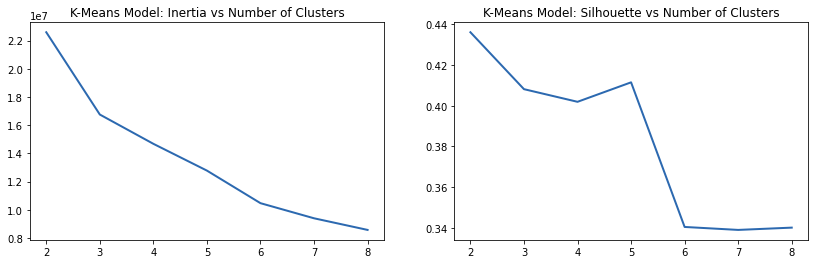

In [160]:
#Plot to find the best number of k using Inertia
#Plot to find the best number of k using Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(n_clusters, inertia_errors, linewidth=2)
ax1.set(title = "K-Means Model: Inertia vs Number of Clusters")
ax2= sns.lineplot(x=n_clusters, y=silhouette_scores, linewidth=2)
ax2.set(title = "K-Means Model: Silhouette vs Number of Clusters")
plt.subplots_adjust(left=0.2, right=2, wspace=0.2, hspace=1)
plt.show();

From the chart above, we can either select 5 or 6 as the optimal number of clusters for our final model. In this case, select ***k=5*** to build our final model.

In [178]:
#Build the final model
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=5, random_state=42, n_init="auto"))
final_model.fit(X_scaled, kmeans__sample_weight=sample_weight)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])

In [179]:
#Get the centroids from the final model
centroids = final_model.named_steps["kmeans"].cluster_centers_
centroids

array([[ 0.12862916,  0.18696417, -0.01258553,  0.2823143 , -0.36552948,
         0.25467777],
       [ 1.2941282 ,  0.10440592,  2.555113  ,  1.4715418 , -0.5107034 ,
         0.562317  ],
       [-0.38082084, -0.30577144, -0.33671635,  0.24151027,  1.22054   ,
        -0.35005137],
       [-0.6316373 , -0.5447706 , -0.5017112 , -0.6733896 , -0.4605037 ,
        -0.49566698],
       [ 2.2712252 ,  2.9592466 ,  0.2940223 ,  0.68999374,  0.4728622 ,
         2.9106953 ]], dtype=float32)

In [180]:
#Get labels from the final model
labels = final_model.named_steps["kmeans"].labels_

#### Principal Component Analysis

In order to reduce high dimensionality and learn what features are the most important in the clustering process, we could use Principal Component Analysis (PCA). Essentially, PCA is a linear dimensionality reduction technique than can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimension sub-space. PCA can preserve the essential parts that have more variation of the data and remove the parts with fewer variation that could be not necessary. 

In [181]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform "X"
X_t = pca.fit_transform(X_scaled)

# Put "X_t" into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4596, 2)


,PC1,PC2
0,-1.05,0.77
1,-1.05,0.77
2,-1.05,0.77
3,-1.05,0.77
4,-1.05,0.77


 Total variance explained by the 2 features: 0.77


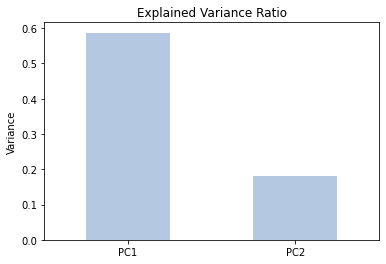

In [182]:
#Expalined variance by the features
print(f" Total variance explained by the 2 features: {round(sum(pca.explained_variance_ratio_),2)}")
variance_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=['PC1', 'PC2'])
variance_ratio.plot(kind="bar", color="#b5c8e2", title="Explained Variance Ratio", ylabel="Variance")
plt.legend('',frameon=False)
plt.xticks(rotation="360")
plt.show();

In [183]:
#Factor loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X.columns)
loadings

,PC1,PC2
asset,0.52,-0.15
nfin,0.47,-0.10
fin,0.37,-0.16
houses,0.39,0.36
debt,0.12,0.89
kgtotal,0.45,-0.13


From the factor loadings and the variance ratio, we can interpret our PCA findings as such:
- PC1 loads strongly with variables that describes assets, non-financial assets and total unrealized capital gains or losses by households. Hence, a large value of PC1 would describe households with high asset overall and a high allocation of asset in non-financial and capital gains. 
- PC2, on the other hand, loads more on equity of residence and debt. Thus, a high value of PC2 would point to households that has houses and more debt as opposed to asset. This makes sense because the negative loadings of variables in PC2 belong to those associate more with asset. 
- Finally, we can conclude that the variables that influence our clustering the most are **asset, capital gains, debt and value of houses**. 

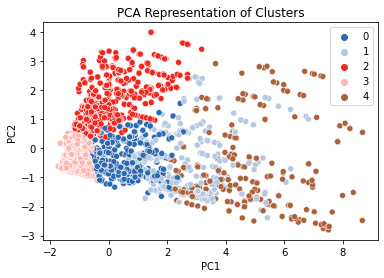

In [185]:
#Visualize clusters and PCA
sns.scatterplot(data=X_pca, x="PC1", y="PC2",hue=labels, palette=palette[:5])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Representation of Clusters");

In [186]:
#Get labels from the final model
#Put clusters into a dataframe
xgb = X.groupby(labels).mean()
xgb

,asset,nfin,fin,houses,debt,kgtotal
0,"10,712,741.00","7,203,007.50","3,509,732.50","1,252,261.25","136,312.12","4,192,265.00"
1,"25,781,750.00","8,740,061.00","17,041,690.00","2,414,946.25","203,731.33","5,524,940.00"
2,"5,592,093.00","3,812,941.00","1,779,151.88","1,382,021.62","799,088.12","1,724,934.12"
3,"1,437,347.00","898,165.62","539,181.44","314,637.22","108,853.74","381,044.06"
4,"34,454,320.00","28,188,478.00","6,265,843.50","1,817,544.88","354,374.75","17,332,710.00"


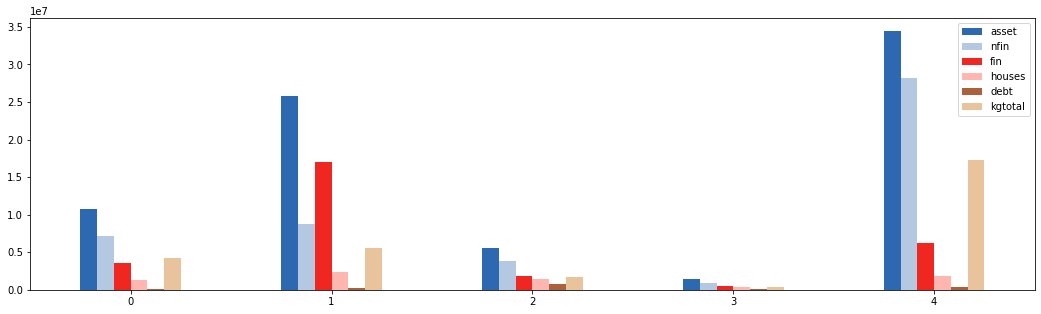

In [188]:
#Visualize each cluster by features
xgb.plot.bar(rot=0, figsize=(18,5), color=palette);

### Agglomerative Hierarchical Clustering

Because categorical data (such as those demographical features we have selected above) does not seem to contribute in determining the distance from the mean. More specifically, the sample space for categorical data is discrete and does not have a natural origin. This makes applying Euclidean distance function difficult to make sense.

Therefore, we can make use of another measurements of similarity such as **Gower distance**. Gower distance is computed as the average of partial dissimilarities across individuals. An observation may contain logical, numberical, or categorical data. Each of the data type will have a different metrics used to calculate the distance. 

Gower distance is always a number between 0 (identical) vs 1 (maximally dissimilar).

The resulting distance matrix can then be fed into Agglomerative Hierarchical Clustering method. We choose the *complete linkage* as suggested by [this paper](https://cdn.aaai.org/ojs/8282/8282-13-11810-1-2-20201228.pdf) since it is robust to the weight of observations. 

In [170]:
#Combine financial and demographical features into one list
#Subset the dataset using these feautres
features = fin_features + demo_features
X_hca = filtered_scfe[features]
X_hca.head()

,asset,nfin,fin,houses,debt,kgtotal,agecl,spendmor,educ,married,lifecl,kids,yesfinrisk
5,"1,240,500.00","1,100,000.00",140500,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0
6,"1,242,500.00","1,100,000.00",142500,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0
7,"1,241,100.00","1,100,000.00",141100,"580,000.00",519700,"164,000.00",3,3,12,2,1,0,0
8,"1,244,000.00","1,100,000.00",144000,"580,000.00",519700,"164,000.00",3,3,12,2,1,0,0
9,"1,241,300.00","1,099,000.00",142300,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0


In [171]:
#Instantiate scaler transformer
ss = StandardScaler()

#Transform "X"
X_scaled_data = ss.fit_transform(X_hca)

#Put "X_scaled_data" into DataFrame
X_hca_scaled = pd.DataFrame(X_scaled_data, columns=X_hca.columns)

print("X_hca_scaled shape:", X_hca_scaled.shape)
X_hca_scaled.head()

X_hca_scaled shape: (4596, 13)


,asset,nfin,fin,houses,debt,kgtotal,agecl,spendmor,educ,married,lifecl,kids,yesfinrisk
0,-0.62,-0.50,-0.54,-0.37,0.67,-0.52,-0.46,-0.33,0.24,2.07,-2.12,-0.68,-0.27
1,-0.62,-0.50,-0.54,-0.37,0.67,-0.52,-0.46,-0.33,0.24,2.07,-2.12,-0.68,-0.27
2,-0.62,-0.50,-0.54,-0.37,0.68,-0.52,-0.46,-0.33,0.24,2.07,-2.12,-0.68,-0.27
3,-0.62,-0.50,-0.54,-0.37,0.68,-0.52,-0.46,-0.33,0.24,2.07,-2.12,-0.68,-0.27
4,-0.62,-0.50,-0.54,-0.37,0.67,-0.52,-0.46,-0.33,0.24,2.07,-2.12,-0.68,-0.27


In [172]:
#Instantiate gower distance matrix
category = [True if x in features else False for x in X_hca.columns]

gd = gower.gower_matrix(X_hca_scaled, cat_features=category)

In [173]:
#Compare matrix and original data shape
print(f"Data shape: {X_hca_scaled.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

Data shape: (4596, 13)
Matrix shape: (4596, 4596)


,0,1,2
0,0.00,0.15,0.23
1,0.15,0.00,0.23
2,0.23,0.23,0.00


In [174]:
#Condense matrix
gdv = squareform(gd,force='tovector')
#output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,472.00,474.00,0.00,2.00
1,10.00,11.00,0.00,2.00


Leaves = 125


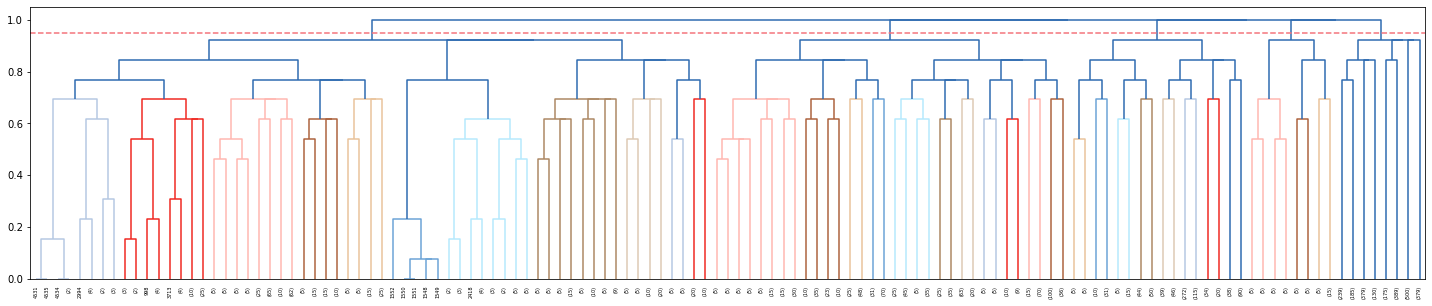

In [175]:
#Visualize hierarchical cluster with denogram
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs)
print(f"Leaves = {len(dn['leaves'])}")
#Determine number of clusters
max_d = 0.95
plt.axhline(y=max_d, linestyle="--", c="#f4737a");


The graph above shows us that the number of clusters we can choose to optimze clustering is around **k = 5**. 

In [176]:
#Append cluster into the original X data
cluster_labels = cut_tree(Z, n_clusters=5).reshape(-1, )
X_hca["k"] = cluster_labels
X_hca.head()

<ipython-input-176-adefde8e2d0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_hca["k"] = cluster_labels


,asset,nfin,fin,houses,debt,kgtotal,agecl,spendmor,educ,married,lifecl,kids,yesfinrisk,k
5,"1,240,500.00","1,100,000.00",140500,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0,0
6,"1,242,500.00","1,100,000.00",142500,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0,0
7,"1,241,100.00","1,100,000.00",141100,"580,000.00",519700,"164,000.00",3,3,12,2,1,0,0,0
8,"1,244,000.00","1,100,000.00",144000,"580,000.00",519700,"164,000.00",3,3,12,2,1,0,0,0
9,"1,241,300.00","1,099,000.00",142300,"580,000.00",518700,"164,000.00",3,3,12,2,1,0,0,0


## Cluster Insight

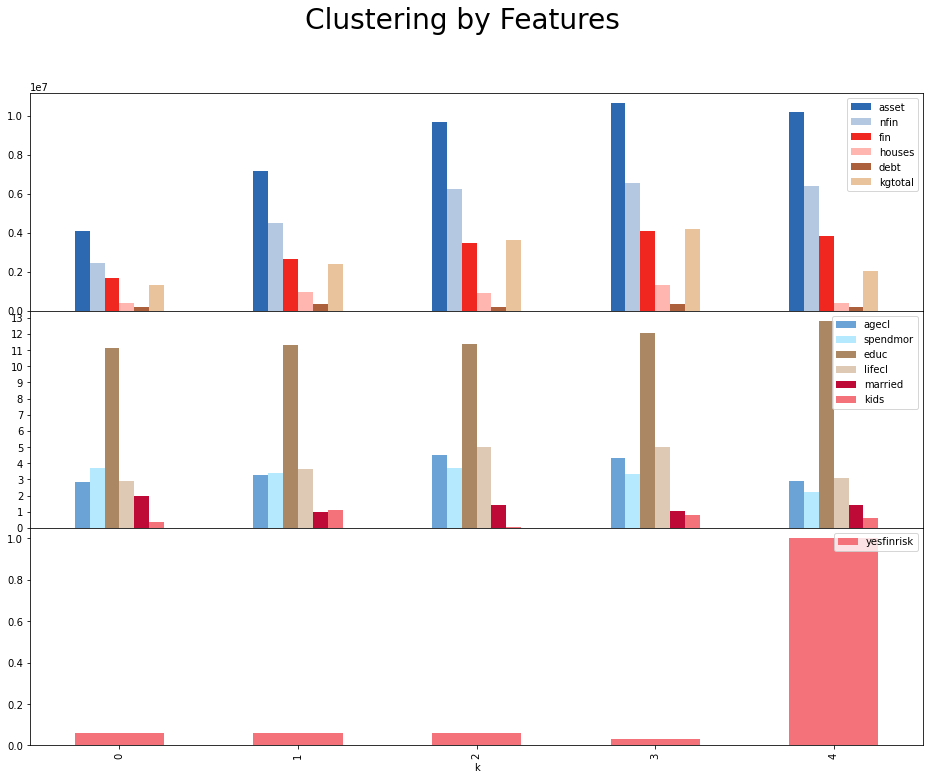

In [177]:
#Visualize cluster
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16,12))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

#Plot graph containing financial features
X_hca.groupby("k")[["asset", "nfin", "fin", "houses", "debt", "kgtotal"]].mean().plot.bar(ax=axs[0], color=palette[:6])

#plot graph containing demographical features
X_hca.groupby("k")[["agecl","spendmor", "educ", "lifecl", "married", "kids"]].mean().plot.bar(ax=axs[1], color=palette[6:])
tick_spacing = 1
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plot graph containing risk features
X_hca.groupby("k")["yesfinrisk"].mean().plot.bar(ax=axs[2], color="#f4737a", label="yesfinrisk")
axs[2].legend(loc="upper right")
t = plt.suptitle("Clustering by Features", fontsize=28)
plt.show();


The plot above shows the average value of the attributes (financial and demographical) for each of the clusters. For example, comparing all the clusters, **cluster 3 and Cluster 4** has the highest value of financial and non-financial assets as well as houses and capital gains. At the same time, these two clusters has the higher average age and education level. This demographical distinction explain why there is a higher level of concentration of assets (both financial and nonfinancial) for these two clusters. In terms of risk appetite, **Cluster 4** show the most willingness to take financial risk, since they would have a more cushioning in terms of asset and the fact that respondents in this cluster would spend more if asset appreciates in value. 

Out of all the cluster, **Cluster 0** has the least amount of asset, low home ownership but would be somewhat willing to take financial risk. This could be explained by the low life cycle, high education level and the fact that this group are more likely to be married or with partner. All clusters seem to indicated the presence of children, except for cluster 2, despite the fact that observations in this cluster are more likely to be married.

Based on the graphs and insights above, we could summarize as a table below:

## Conclusion

We conclude the portfolio by summarizing the answers to the two questions proposed:

- How can we cluster business owners in the US to better identify different types of investors?
    - Using KMeans as a starting point and then refining through Agglomerative Hierarchical Clustering, we are able to identify **5 clusters** with characteristics as detailed in the table below. 

|Cluster   |Demographical Features   |Financial Features   |Risk Capacity   |Suggested Portfolio Approach   |
|---|---|---|---|---|
|Cluster 0   |Under 45, not married   |Low asset, some capital gains, no house   |Medium   |Dividend-paying stocks and coupon-yielding bonds   |
|Cluster 1   |Age 45 - 54, married, has kids   |Low asset, own house, some  capital gains, high debt   |Medium   |Balanced funds   |
|Cluster 2   |Age 55 - 64, no kids |Medium asset, own house, low debt   |Medium  |Balanced funds, 40/60 Bond/Stocks split   |
|Cluster 3   |Age 55 - 64, married, no kids|High asset, high house value, high debt, high capital gains|Low   |Low-cost index funds   |
|Cluster 4   |Under 35, no kids|High asset, no house, some capital gains   |High   |Growth stocks, commodity and (or) money market funds   |


- What are the influential attributes in determining the clusters?
    - By making use of Principal Component Analysis, we were able to extract the most influential financial features such as **asset, capital gains, debt and value of houses.**